In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from myfunctions import set_importer, scores
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV, RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
pd.set_option('display.max_columns', None)

sns.set_style("whitegrid")
%matplotlib inline

# setting font size for all plots
font = {'size'   : 16}

plt.rc('font', **font)

In [3]:
# importing the necessary sets
X_train = set_importer('../analysis-dfs/X_train_ordinal_encoded.csv')
X_test = set_importer('../analysis-dfs/X_test_ordinal_encoded.csv')

y_train = set_importer('../analysis-dfs/y_train_prepared_2.csv', y=True)
y_test = set_importer('../analysis-dfs/y_test_prepared.csv', y=True)

display(X_train.shape)
X_train.head(10)

(29852, 16)

,gps_height,longitude,latitude,region_code,district_code,population,permit,construction_year,basin,extraction_type_class,management_group,payment,quality_group,quantity_group,source_class,waterpoint_type_group
0,-0.356274,1.723728,-1.640197,-0.393261,-0.194167,1.366671,0.66262,0.801349,-1.550911,-1.417821,-0.314342,-0.783634,-0.399189,-1.266481,-0.529080,-0.832690
1,-0.884573,-0.348901,-1.036569,-0.240379,0.092932,-0.675954,0.66262,-1.231119,-1.159302,-0.652663,-0.314342,-0.190823,-0.399189,-0.677096,1.788588,-0.832690
2,-0.884573,-0.267184,-1.007222,-0.240379,0.092932,-0.675954,0.66262,-1.231119,-1.159302,-0.652663,-0.314342,-0.783634,-0.399189,-0.087711,1.788588,-0.832690
3,-0.693453,1.097498,-0.507180,-0.597103,-0.385566,1.025095,0.66262,0.816731,-0.767692,0.112494,-0.314342,-0.190823,0.853827,-0.677096,-0.529080,0.319603
4,0.993994,-0.536809,1.177516,0.167305,-0.194167,1.366671,-1.50916,0.828011,-0.376083,0.112494,-0.314342,0.401987,2.106843,0.501674,-0.529080,0.319603
5,0.933395,-0.798928,1.241827,0.116345,-0.481266,2.732976,0.66262,0.815706,-0.376083,0.112494,-0.314342,-0.783634,-0.399189,-0.677096,-0.529080,0.319603
6,-0.884573,-1.349221,1.396173,0.065384,-0.385566,-0.675954,0.66262,-1.231119,-0.376083,0.877651,-0.314342,-0.783634,-0.399189,-0.677096,-0.529080,1.471897
7,-0.884573,-0.072088,1.885445,0.014424,-0.481266,-0.675954,-1.50916,-1.231119,-0.376083,0.877651,1.079108,-0.783634,0.853827,1.091059,-0.529080,1.471897
8,0.736060,0.033395,-1.704817,-0.342300,-0.289867,-0.341209,0.66262,0.809553,-1.550911,-0.652663,-0.314342,0.401987,-0.399189,-1.266481,-0.529080,-0.832690
9,2.404861,-0.405766,-1.092367,-0.291340,-0.289867,-0.675954,-1.50916,0.793146,-1.159302,-0.652663,-0.314342,0.994798,-0.399189,1.091059,-0.529080,-0.832690


## Building Itertative models to find the Best Decision Tree Model

### Decision Tree Classifier with criterion gini

In [4]:
dtc_gini = DecisionTreeClassifier(criterion='gini', random_state=21)

dtc_gini.fit(X_train, y_train)

y_preds_gini = dtc_gini.predict(X_test)
y_probs_gini = dtc_gini.predict_proba(X_test)[:, 1]

In [5]:
print('Model scores with gini criterion')
scores(y_test, y_preds_gini, y_probs_gini)

Model scores with gini criterion
The precision score is:	 0.8490742910710101
The recall score is:	 0.5603154964429322
The accuracy score is:	 0.542748492001049
The log loss is:	 15.788991389520987
The auc is:		 0.5016583428437343


### Decision Tree Classifier with criterion entropy

In [6]:
dtc_entropy = DecisionTreeClassifier(criterion='entropy', random_state=21)

dtc_entropy.fit(X_train, y_train)

y_preds_entropy = dtc_entropy.predict(X_test)
y_probs_entropy = dtc_entropy.predict_proba(X_test)[:, 1]

In [7]:
print('Model scores with gini criterion')
scores(y_test, y_preds_entropy, y_probs_entropy)

Model scores with gini criterion
The precision score is:	 0.8559880239520958
The recall score is:	 0.44215898546241883
The accuracy score is:	 0.46393915552058745
The log loss is:	 18.51095234925875
The auc is:		 0.5125949262455071


Both models did not do well compared to the best model in logistic regression part. Maybe tunning will help. 
I will continue with the entropy criterion since it perfomed better without ant tunning needed.

#### min_samples_split

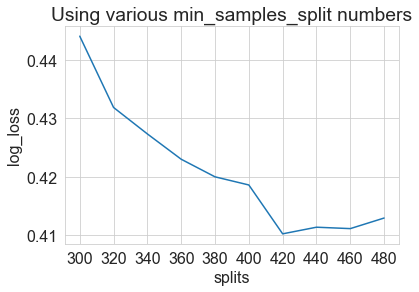

In [8]:
splits = np.arange(300, 500, 20)
log_loss_means = []

for split in splits:
    dtc_model = DecisionTreeClassifier(criterion='entropy', random_state=21, min_samples_split=split)
    log_loss_means.append( -cross_val_score(dtc_model, X_train, y_train, scoring='neg_log_loss').mean() )

plt.plot(splits, log_loss_means)
plt.xlabel('splits')
plt.xticks(splits)
plt.ylabel('log_loss')
plt.title('Using various min_samples_split numbers')
plt.show() 

The minimum number of samples required to split an internal node, with less log_loss is 420 samples

#### min_samples_leaf

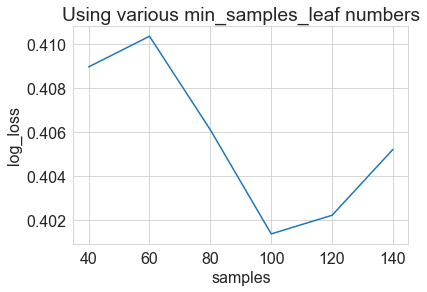

In [11]:
samples = np.arange(40,160,20)
log_loss_means = []

for sample in samples:
    dtc_model = DecisionTreeClassifier(criterion='entropy', random_state=21, min_samples_split=420, min_samples_leaf=sample)
    log_loss_means.append( -cross_val_score(dtc_model, X_train, y_train, scoring='neg_log_loss').mean() )

plt.plot(samples, log_loss_means)
plt.xlabel('samples')
plt.xticks(samples)
plt.ylabel('log_loss')
plt.title('Using various min_samples_leaf numbers')
plt.show() 

The minimum number of samples required to be at a leaf node, producing less log loss are 100 samples.

#### max_depth

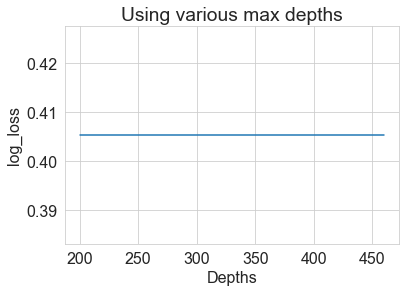

In [13]:
depths = np.arange(200,470,20)
log_loss_means = []

for depth in depths:
    dtc_model = DecisionTreeClassifier(criterion='entropy', random_state=21, min_samples_split=460, min_samples_leaf=100, max_depth=depth)
    log_loss_means.append( -cross_val_score(dtc_model, X_train, y_train, scoring='neg_log_loss').mean() )

plt.plot(depths, log_loss_means)
plt.xlabel('Depths')
plt.ylabel('log_loss')
plt.title('Using various max depths')
plt.show()

Max depth has no effect.

#### max_features

/home/iain/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/iain/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/iain/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/iain/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.wa

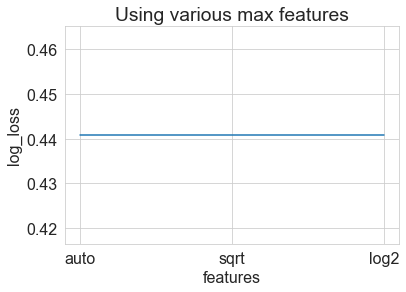

In [14]:
features = ['auto', 'sqrt', 'log2']
log_loss_means = []

for feature in features:
    dtc_model = DecisionTreeClassifier(criterion='entropy', random_state=21, min_samples_split=460, min_samples_leaf=70, max_features=feature)
    log_loss_means.append( -cross_val_score(dtc_model, X_train, y_train, scoring='neg_log_loss').mean() )

plt.plot(features, log_loss_means)
plt.xlabel('features')
plt.ylabel('log_loss')
plt.xticks(features)
plt.title('Using various max features')
plt.show()

No effect was notice hence will stick with these parameters: criterion='entropy', random_state=21, min_samples_split=460, min_samples_leaf=70.

## The best model

In [15]:
best_dtr_model = DecisionTreeClassifier(criterion='entropy', random_state=21, min_samples_split=460, min_samples_leaf=70)
best_dtr_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', min_samples_leaf=70,
                       min_samples_split=460, random_state=21)

In [16]:
y_preds_best = best_dtr_model.predict(X_test)
y_preds_best_probs = best_dtr_model.predict_proba(X_test)[:, 1]
print('Decision Tree Classifier best model results on the testing set.')
scores(y_test, y_preds_best, y_preds_best_probs)

Decision Tree Classifier best model results on the testing set.
The precision score is:	 0.8650190114068441
The recall score is:	 0.35184039591710486
The accuracy score is:	 0.4038814581694204
The log loss is:	 1.0795925417093906
The auc is:		 0.5751580548652366


checking if there is overfitting.

In [17]:
y_train_best = best_dtr_model.predict(X_train)
y_train_best_probs = best_dtr_model.predict_proba(X_train)[:, 1]
print('Decision Tree Classifier best model results on the training set')
scores(y_train, y_train_best, y_train_best_probs)

Decision Tree Classifier best model results on the training set
The precision score is:	 0.8567722938867078
The recall score is:	 0.8187726115503149
The accuracy score is:	 0.8409486801554334
The log loss is:	 0.3481531089891455
The auc is:		 0.9218793419010851


Overfitting is not present.

/home/iain/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


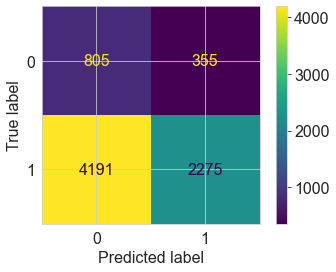

In [18]:
# confusion matrix
plot_confusion_matrix(best_dtr_model, X_test, y_test)
plt.show()

This model clearly perfomrs worse than the best logistic regression model. I will ensemble methods to see if I can boost

## Bagged Tree Classifier

Before intializing a bagging classifier model I will first start with finding the best number of estimators.

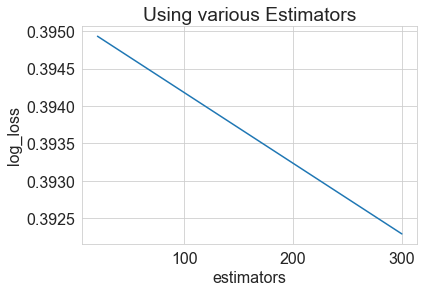

In [21]:
estimators = [20,300]
log_loss_means = []

for estimator in estimators:
    btc_model = BaggingClassifier(DecisionTreeClassifier(criterion='entropy', random_state=21, min_samples_split=460, min_samples_leaf=70), n_estimators=estimator)
    log_loss_means.append( -cross_val_score(btc_model, X_train, y_train, scoring='neg_log_loss').mean() )

plt.plot(estimators, log_loss_means)
plt.xlabel('estimators')
plt.ylabel('log_loss')
plt.title('Using various Estimators')
plt.show()

n_estimators = 200 produced a lesser log loss

### Creating a baggingClassifier

In [ ]:
bagging_classifier = BaggingClassifier(DecisionTreeClassifier(criterion='entropy', random_state=21, min_samples_split=460, min_samples_leaf=70), n_estimators=200)
bagging_classifier.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                        min_samples_leaf=70,
                                                        min_samples_split=460,
                                                        random_state=21),
                  n_estimators=200)

In [ ]:
y_test_bag = bagging_classifier.predict(X_test)
y_test_bag_probs = bagging_classifier.predict_proba(X_test)[:, 1]
print('Decision Tree Classifier best model results on the test set')
scores(y_test, y_test_bag, y_test_bag_probs)

Decision Tree Classifier best model results on the training set
The precision score is:	 0.8452995463788519
The recall score is:	 0.8357562635323229
The accuracy score is:	 0.7310516653553633
The log loss is:	 0.6584896541834552
The auc is:		 0.5044697329266082


/home/iain/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


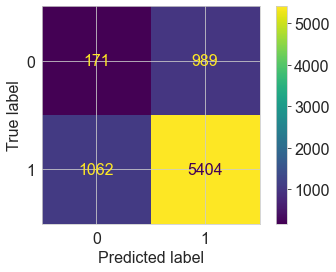

In [ ]:
# confusion matrix
plot_confusion_matrix(bagging_classifier, X_test, y_test)
plt.show()

## Random forest Classifier

Before intializing a Random forest classifier model I will first start with finding the best number of estimators. Using the same parameters as the one obtained in the best decision tree regression model.

In [ ]:
grid_params = {
    'criterion': ['entropy'],
    'min_samples_split': [460],
    'min_samples_leaf': [70],
    'n_estimators': [10,100,200,300]
}


In [ ]:
rfc = RandomForestClassifier()
grid_search = GridSearchCV(rfc, grid_params, cv=4)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy'], 'min_samples_leaf': [70],
                         'min_samples_split': [460],
                         'n_estimators': [10, 100, 200, 300]})

In [ ]:
grid_search.best_params_

{'criterion': 'entropy',
 'min_samples_leaf': 70,
 'min_samples_split': 460,
 'n_estimators': 200}

The best parameter for the RandomForestClassifier are {'criterion': 'entropy', 'min_samples_leaf': 70, 'min_samples_split': 460, 'n_estimators': 200}

In [ ]:
rf_classifier = RandomForestClassifier(criterion='entropy', random_state=21, min_samples_split=460, min_samples_leaf=70, n_estimators=200)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', min_samples_leaf=70,
                       min_samples_split=460, n_estimators=200,
                       random_state=21)

In [ ]:
y_test_rf_preds = rf_classifier.predict(X_test)
y_test_rf_probs = rf_classifier.predict_proba(X_test)[:, 1]
print('RandomForest Classifier best model results on the training set')
scores(y_test, y_test_rf_preds, y_test_rf_probs)

RandomForest Classifier best model results on the training set
The precision score is:	 0.8649858272415336
The recall score is:	 0.896690380451593
The accuracy score is:	 0.7937319695777603
The log loss is:	 0.5406626313934763
The auc is:		 0.5538816435039517


/home/iain/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


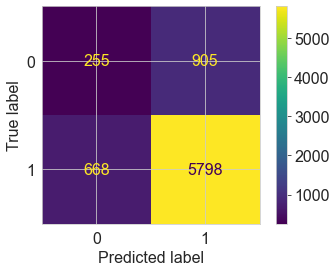

In [ ]:
# confusion matrix
plot_confusion_matrix(rf_classifier, X_test, y_test)
plt.show()

This model performed better the the logistic regression, but can it do better.